# 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import torch

# 2. Defining Model

RoBERTa, or Robustly optimized BERT approach, is a natural language processing (NLP) model introduced by Facebook AI Research (FAIR) in 2019.

It is based on the BERT (Bidirectional Encoder Representations from Transformers) architecture, which has proven to be highly effective in various NLP tasks (especially the text understanding tasks)

BERT is an encoder only model, trained using Masked Language Modelling(MLM) and Next Sentence prediction(NSP). Whereas Roberta was trained using only MLM.

In [ ]:
MODEL_NAME = 'roberta-base'
TRAIN = True
RESET = True
INPUT = 'nbme-tensorflow-bert-baseline'

In [ ]:
input_path = f'../input/{INPUT}/'
output_path = f'./'

data_exists = False

# 3. Data Preprocessing

## 3.1. Importing Data

In [ ]:
patient_note = pd.read_csv("patient_notes.csv")
print(patient_note.head(5))
patient_note.info()

In [ ]:
features = pd.read_csv("features.csv")
print(features.head(5))
features.info()

   feature_num  case_num                                       feature_text
0            0         0  Family-history-of-MI-OR-Family-history-of-myoc...
1            1         0                 Family-history-of-thyroid-disorder
2            2         0                                     Chest-pressure
3            3         0                              Intermittent-symptoms
4            4         0                                        Lightheaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [ ]:
train = pd.read_csv("train.csv")
print(train.head(5))
train.info()

          id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   
1  00016_001         0      16            1   
2  00016_002         0      16            2   
3  00016_003         0      16            3   
4  00016_004         0      16            4   

                                 annotation              location  
0          ['dad with recent heart attcak']           ['696 724']  
1             ['mom with "thyroid disease']           ['668 693']  
2                        ['chest pressure']           ['203 217']  
3      ['intermittent episodes', 'episode']  ['70 91', '176 183']  
4  ['felt as if he were going to pass out']           ['222 258']  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14300 entries, 0 to 14299
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14300 non-null  object
 1   case_num     14300 non-null  int64 
 2   pn_num       14300 non-null  int

## 3.2. Merging Data

In [ ]:
train = train.merge(patient_note,on=['case_num','pn_num'])
train = train.merge(features,on=['case_num','feature_num'])
train.head(5)

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...


## 3.3. Splitting Data for Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=0.2,shuffle=True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.array(train['feature_num']))
train['Target'] = le.transform(train['feature_num'])

## 3.4. Tokenization

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('my_tokenizer',normalization=True)

In [ ]:
traing = train.groupby('pn_num')

In [ ]:
N_CLASSES = len(pd.unique(train['Target']))+1

In [ ]:
def getlocation(lc):
    lc = str(lc).replace("'","")
    lc = lc.replace(',', ";")
    lc = lc.replace('[', "")
    lc = lc.replace(']', "")

    k = lc.split(';')
    s = []
    for list in k:
        if(len(list.split()) == 1):
            s.append((int(list.split()[0]),int(list.split()[0])))
        elif(len(list.split()) == 2):
            s.append((int(list.split()[0]),int(list.split()[1])))
    return sorted(s, key=lambda x:x[0])

## 3.5. Defining Labels and Masks








*   Tokenizing sequences from training data for an NLP task.

*   Utilizing the Hugging Face Transformers library for efficient tokenization.


*   Labeling sequences based on word locations, handling overlaps in positions.

*   Preparing arrays for model training, including sequences, attention masks, and one-hot encoded labels, underscoring the importance of meticulous data preparation.





In [ ]:
sequences, labels, masks = [], [], []

for df in traing:
    dftemp = df[1]
    pn = dftemp['pn_history'].iloc[0]

    tokens = tokenizer.encode_plus(pn,max_length=350,padding='max_length',truncation=True,return_offsets_mapping=True)

    sequence = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    words = tokens['offset_mapping']

    label = np.array([143 for _ in range(350)])

    check = True
    for index, row in dftemp.iterrows():
        tgt = row['Target']
        for i, (w_start, w_end) in enumerate(words):
             for start,end in getlocation(row.location):
                if w_start < w_end and (w_start >= start) and (w_end <= end):
                    label[i] = tgt
                    check = False
                if w_start >= w_end:
                     break

    if not check:
        sequences.append(sequence)
        masks.append(attention_mask)
        labels.append(label)

# Formats the data
sequences = np.array(sequences).astype(np.int32)
masks = np.array(masks).astype(np.uint8)
labels = np.array(tf.keras.utils.to_categorical(labels,N_CLASSES)).astype(np.uint8)

In [ ]:
sequences[1]

array([    0,  1360,   854,    73,   673,   256,   230, 30104,  3842,
        1941,  5289,  2444,  2371,   230,    73,   673, 12925, 11328,
         221, 18103,  1862,     4, 33714,  1691,   132,    12,   246,
       11757,    83, 14740,     4,  3779, 33714,  1691,   208, 13083,
       28082, 14079,     4, 30540,  8127, 14895,  7981, 16005,  5758,
        5969, 31595,  1862, 44094,     4,  3779, 15823,  1723,  4248,
       11932,  1723,     6,  3779,   289, 17167,  2796,  1691,   195,
          12,   401, 18685,  1723,   208,  2444,  8041,  3779, 33714,
        1691,     4,  3779,   226,  2336,  2685,   155,    12,   306,
       18335,     6, 29856,  8640,  1889,  1437, 34157, 11932,  1723,
       18463,  2547,     4, 12925, 31963,  9459, 10649, 21260,   100,
       29076,  1862,   208,  7912,     6, 22980, 12435,  5121, 29892,
        3858,  4923, 32060, 12925, 31963, 10652, 28866, 14940,     4,
       12925,  3703,    83, 14857,  3850,  8800, 39833,  5382,     6,
       10649, 21260,

In [ ]:
dftemp

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,Target
14199,95333_915,9,95333,915,['no sick contacts'],['421 437'],Stephanie madden is a 20 year old woman compla...,No-known-illness-contacts,141
13399,95333_907,9,95333,907,[],[],Stephanie madden is a 20 year old woman compla...,No-rash,133
13499,95333_908,9,95333,908,['Nausea'],['354 360'],Stephanie madden is a 20 year old woman compla...,Nausea,134
13899,95333_912,9,95333,912,[],[],Stephanie madden is a 20 year old woman compla...,Family-history-of-migraines,138
14299,95333_916,9,95333,916,['Subjective fever'],['314 330'],Stephanie madden is a 20 year old woman compla...,Subjective-fever,142
12699,95333_900,9,95333,900,"['Did not respond to ibuprofen', 'Did not resp...","['212 240', '212 230;242 249']",Stephanie madden is a 20 year old woman compla...,No-relief-with-Motrin-OR-no-relief-with-tylenol,126
13799,95333_911,9,95333,911,[],[],Stephanie madden is a 20 year old woman compla...,Meningococcal-vaccine-status-unknown,137
12899,95333_902,9,95333,902,['yesterday'],['76 85'],Stephanie madden is a 20 year old woman compla...,1-day-duration-OR-2-days-duration,128
13099,95333_904,9,95333,904,[],[],Stephanie madden is a 20 year old woman compla...,Global-headache-OR-diffuse-headache,130
14099,95333_914,9,95333,914,['photobia'],['274 282'],Stephanie madden is a 20 year old woman compla...,Photophobia,140


# 4. Modelling

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
import dill
import matplotlib.pyplot as plt

## 4.1. Defining Hyperparameters

In [ ]:
TRAIN_SPLIT = 0.9
BATCH_SIZE = 12
EPOCHS = 20
SEED = 999

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        ((sequences, masks), labels))

## 4.2. Partitioning Datset



*   We are partitioning a TensorFlow dataset into training, validation, and test sets with specified split ratios.

*   To maintain reproducibility, we are optionally shuffling the dataset using a seed value of 12 for consistent split distributions.

*   We are determining split sizes based on provided ratios and returning the resulting datasets.

*   Emphasizing modularity, this function serves as a versatile tool for managing dataset splits in machine learning workflows.

In [ ]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
samples = sequences.shape[0]
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(
    train_dataset,
    train_split=0.9,
    val_split=0.1,
    test_split=0,
    ds_size=samples)

train_dataset, val_dataset,test_dataset

(<TakeDataset element_spec=((TensorSpec(shape=(350,), dtype=tf.int32, name=None), TensorSpec(shape=(350,), dtype=tf.uint8, name=None)), TensorSpec(shape=(350, 144), dtype=tf.uint8, name=None))>,
 <TakeDataset element_spec=((TensorSpec(shape=(350,), dtype=tf.int32, name=None), TensorSpec(shape=(350,), dtype=tf.uint8, name=None)), TensorSpec(shape=(350, 144), dtype=tf.uint8, name=None))>,
 <SkipDataset element_spec=((TensorSpec(shape=(350,), dtype=tf.int32, name=None), TensorSpec(shape=(350,), dtype=tf.uint8, name=None)), TensorSpec(shape=(350, 144), dtype=tf.uint8, name=None))>)

In [ ]:
# Creates repeating generators with options and the set batch sizer with the datasets
train_dataset = train_dataset.repeat().batch(BATCH_SIZE)
val_dataset = val_dataset.repeat().batch(BATCH_SIZE)

train_dataset, val_dataset

(<BatchDataset element_spec=((TensorSpec(shape=(None, 350), dtype=tf.int32, name=None), TensorSpec(shape=(None, 350), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 350, 144), dtype=tf.uint8, name=None))>,
 <BatchDataset element_spec=((TensorSpec(shape=(None, 350), dtype=tf.int32, name=None), TensorSpec(shape=(None, 350), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 350, 144), dtype=tf.uint8, name=None))>)

In [ ]:
steps_per_epoch = (samples * TRAIN_SPLIT) // BATCH_SIZE
validation_steps = (samples * 0.1) // BATCH_SIZE

steps_per_epoch, validation_steps

(75.0, 8.0)

## 4.3. Defining Early stopping


**Early Stopping**


*   Early stopping is a regularization technique used during training in machine learning models to prevent overfitting.



*   The process involves monitoring a specified metric (e.g., validation loss) during training and halting the training process once the metric stops improving.

*   Early stopping helps prevent the model from learning noise in the training data and promotes generalization to unseen data.





*   It's a crucial tool for optimizing model performance and efficiency by stopping training when further iterations are unlikely to yield better results.



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience=3)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{output_path}/model.h5',
    monitor="f1_score",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)

In [ ]:
callbacks = [early_stopping, model_checkpoint]

## 4.4. Model Building

In [ ]:
def build_model(data_exists, config):

    # Creates input layers
    tokens = tf.keras.layers.Input(shape=(350,), name = 'tokens', dtype=tf.int32)
    attention = tf.keras.layers.Input(shape=(350,), name = 'attention', dtype=tf.int32)

    if data_exists:
        # Initializes the AutoConfig Model from disk
        backbone = TFAutoModel.from_config(config)
    else:
        # Initializes the AutoConfig Model from the cloud
        backbone = TFAutoModel.from_pretrained(MODEL_NAME, config=config)

    # Output layers
    out = backbone(tokens, attention_mask=attention)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    # Sets the output activation to softmax
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(out)

    # Generates the model structure
    model = tf.keras.Model([tokens, attention], out)

    # Compiles the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=[tfa.metrics.F1Score(num_classes=N_CLASSES, average='micro')])

    return model

## 4.5. Model Fitting

In [ ]:
def fit_model(model, train_ds, val_ds, steps_per_epoch, validation_steps, callbacks, epochs=10):

    # Fits the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        #callbacks=callbacks,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps)

    return model, history

In [ ]:
if data_exists:
    # If data exsists, loads the config from disk
    config = AutoConfig.from_pretrained(f'{input_path}/my_tokenizer/config.json')
else:
    # Else, downloads & initializes the config from the cloud
    config = AutoConfig.from_pretrained(MODEL_NAME)
    config.save_pretrained(f'my_tokenizer')

In [ ]:
import os

# Builds the model
model = build_model(data_exists, config)
# Fits the model
model, history = fit_model(
        model,
        train_dataset,
        val_dataset,
        steps_per_epoch,
        validation_steps,
        callbacks,
        epochs=EPOCHS)

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20
75/75 [==============================] - 96s 710ms/step - loss: 0.9214 - f1_score: 0.8796 - val_loss: 0.6552 - val_f1_score: 0.9031
Epoch 2/20
75/75 [==============================] - 45s 600ms/step - loss: 0.6606 - f1_score: 0.8981 - val_loss: 0.5287 - val_f1_score: 0.8964
Epoch 3/20
75/75 [==============================] - 44s 588ms/step - loss: 0.4495 - f1_score: 0.9040 - val_loss: 0.2479 - val_f1_score: 0.9301
Epoch 4/20
75/75 [==============================] - 43s 575ms/step - loss: 0.2769 - f1_score: 0.9208 - val_loss: 0.1575 - val_f1_score: 0.9432
Epoch 5/20
75/75 [==============================] - 43s 569ms/step - loss: 0.2022 - f1_score: 0.9333 - val_loss: 0.1434 - val_f1_score: 0.9475
Epoch 6/20
75/75 [==============================] - 43s 580ms/step - loss: 0.1599 - f1_score: 0.9434 - val_loss: 0.1279 - val_f1_score: 0.9551
Epoch 7/20
75/75 [==============================] - 43s 569ms/step - loss: 0.1311 - f1_score: 0.9518 - val_loss: 0.0938 - val_f1_score: 0.9648

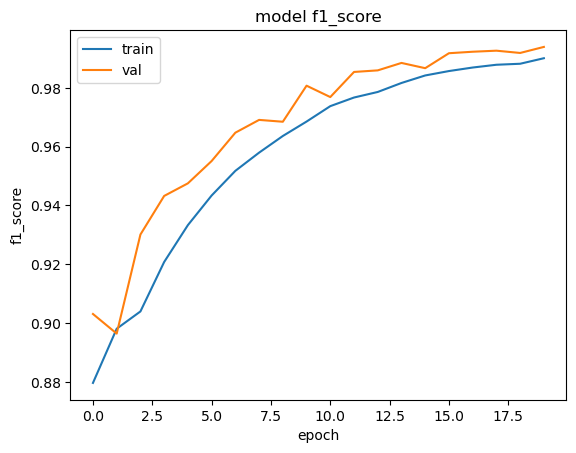

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

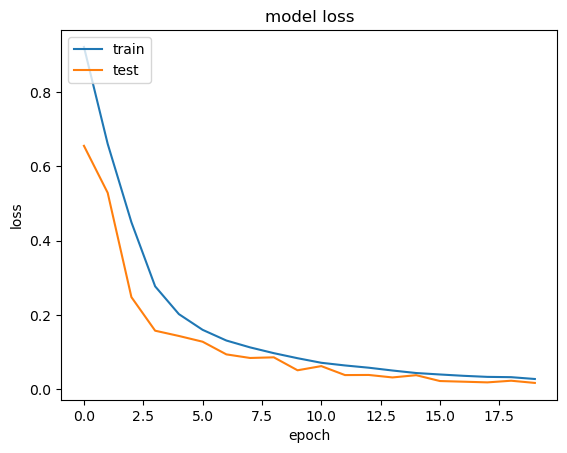

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


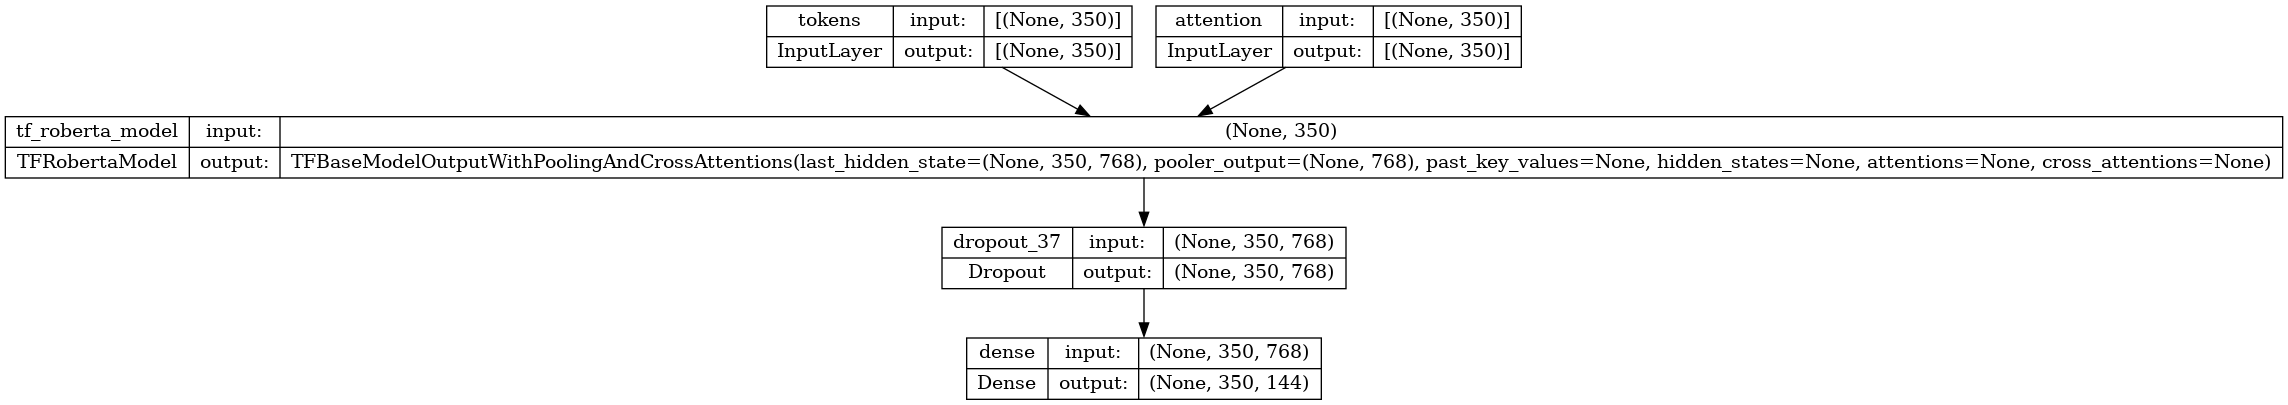

In [ ]:
tf.keras.utils.plot_model(
            model=model,
            show_shapes=True,
            show_dtype=False,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=True,
            dpi=96,
            layer_range=None)

In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
#test_dataset = tf.data.Dataset.from_tensor_slices(
#        ((test_sequences, test_masks),)).batch(BATCH_SIZE).with_options(options)

In [ ]:
test.head(10)

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
8483,55584_515,5,55584,515,[],[],"26 yo F, f/u after ED visit for heart pounding...",Fatigue-OR-Difficulty-concentrating
10177,73296_702,7,73296,702,"['problems with her periods', 'periods have be...","['34 59', '107 134', '107 124;139 144', '146 1...",35-year-old female complaining of problems wit...,heavy-periods-OR-irregular-periods
4200,20001_216,2,20001,216,['44 yo'],['4 9'],CC: 44 yo female c/o irregular periods\r\nHPI:...,44-year
2800,20001_202,2,20001,202,[],[],CC: 44 yo female c/o irregular periods\r\nHPI:...,IUD
13480,94372_908,9,94372,908,[],[],20 y female here in the clinic with c/o headac...,Nausea
11437,81678_806,8,81678,806,['difficulty falling asleep'],['177 187;193 207'],Loraine Wicks is a 67 year old female with pas...,Difficulty-falling-asleep
13781,94465_911,9,94465,911,[],[],20 year old female. Complains of headache toda...,Meningococcal-vaccine-status-unknown
11493,84095_806,8,84095,806,['difficulty falling alseep'],['125 150'],67 y/o F c/o insomnia for the past 3 weeks. He...,Difficulty-falling-asleep
8299,57026_513,5,57026,513,"['feeling hot', 'clammy']","['339 350', '365 371']",26 year oild female with no PMH who presents w...,Feels-hot-OR-Feels-clammy
12116,80706_813,8,80706,813,['Saw image of son last night'],['286 313'],Pt is 67 yr female presenting with trouble sle...,Visual-hallucination-once


In [ ]:
test['Target'] = le.transform(test['feature_num'])
test_gt = test[['id','annotation','location']]
test_pred = test.drop(['annotation','location'],axis=1)



*   We are processing predictions from a test dataset grouped by 'pn_num,' extracting sequences, attention masks, and offset mappings.

*   For each group, we tokenize the 'pn_history' using a designated tokenizer, and construct target arrays along with associated row IDs.



*   The resulting sequences, masks, and offsets are organized for subsequent analysis or model evaluation.




*   The finalized data structures, including NumPy arrays for sequences and masks, and a list of dictionaries mapping targets to row IDs, are prepared for downstream tasks like evaluation or result interpretation.






In [ ]:
test_sequences, test_masks, test_offsets = [], [],[]
row_ids = []
targets = []

testgrp = test_pred.groupby('pn_num')

for g1 in testgrp:

    gdf = g1[1]
    pn_history  = gdf.iloc[0].pn_history
    targets.append([])
    row_ids.append([])

    test_tokens = tokenizer.encode_plus(pn_history, max_length=350, padding='max_length',truncation=True, return_offsets_mapping=True)
    test_sequence = test_tokens['input_ids']
    test_attention_mask = test_tokens['attention_mask']

    # BUILD THE TARGET ARRAY
    offset = test_tokens['offset_mapping']

    for index, row in gdf.iterrows():

        targets[-1].append(row['Target'])
        row_ids[-1].append(row['id'])

    test_sequences.append(test_sequence)
    test_masks.append(test_attention_mask)
    test_offsets.append(offset)

test_sequences = np.array(test_sequences).astype(np.int32)
test_masks = np.array(test_masks).astype(np.uint8)
targets_to_row_ids = [dict(zip(a,b)) for a,b in zip(targets,row_ids)]

In [ ]:
# Builds the TensorFlow dataset with the embeddings arrays
test_dataset = tf.data.Dataset.from_tensor_slices(((test_sequences, test_masks),)).batch(BATCH_SIZE)

# 5. Data Postprocessing

In [ ]:
preds = model.predict(test_dataset,batch_size=BATCH_SIZE)
preds = np.argmax(preds, axis=-1)

79/79 [==============================] - 18s 193ms/step


## 5.1. Decoding entities from Positions



1.   The function decode_position converts position information into a string format for easy interpretation, utilizing a semicolon to separate start and end positions.

2.    The translate function processes model predictions (preds), mapping them to original row IDs using targets_to_row_ids and incorporating offset information (offsets).

3.    It iterates through the predictions, identifying labeled segments and their corresponding start and end positions based on token offsets.

4.    The extracted information is organized into a DataFrame (df), containing IDs and corresponding decoded locations.

5.    This translation mechanism is useful for converting model predictions into a human-readable format, facilitating result interpretation and analysis.



In [ ]:
def decode_position(pos):

    return ";".join([" ".join(np.array(p).astype(str)) for p in pos])


def translate(preds,targets_to_row_ids,offsets):

    all_ids = []
    all_pos = []

    for k in range(len(preds)):

        offset = offsets[k]
        pred = preds[k]
        targets_to_ids = targets_to_row_ids[k]

        prediction = {targets_to_ids[t]:[] for t in targets_to_ids}
        i = 0

        while i<350:
            label = pred[i]

            if label == 143:
                i += 1
                continue
            if label in targets_to_ids:
                key = targets_to_ids[label]
                start = offset[i][0]
                while i<350:
                    if pred[i] != label:
                        break
                    else:
                        end = max(offset[i])
                    i += 1
                if  end == 0:
                    break
                prediction[key].append((start, end))
            else:
                i+=1

        for key in prediction:

            all_ids.append(key)
            all_pos.append(decode_position(prediction[key]))

    df = pd.DataFrame({
        "id": all_ids,
        "location": all_pos
    })
    return df

In [ ]:
sub = translate(preds, targets_to_row_ids, test_offsets)
sub = sub.merge(test,left_on='id', right_on='id')
#sub.to_csv('submission.csv',index=False)
sub.head(50)

,id,location_x,case_num,pn_num,feature_num,annotation,location_y,pn_history,feature_text,Target
0,00016_003,70 91,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms,3
1,00016_004,,0,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,Lightheaded,4
2,00041_008,,0,41,8,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Caffeine-use,8
3,00046_003,,0,46,3,['sporadically'],['184 196'],Mr. Cleveland is a 17yo M who was consented by...,Intermittent-symptoms,3
4,00046_008,,0,46,8,[],[],Mr. Cleveland is a 17yo M who was consented by...,Caffeine-use,8
5,00082_012,6 7,0,82,12,['M'],['6 7'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Male,12
6,00082_002,,0,82,2,[],[],17 yo M w/ no cardiac or arrhythmia PMH presen...,Chest-pressure,2
7,00082_000,,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,0
8,00100_001,,0,100,1,['Mom-thyroid problem'],['714 733'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-thyroid-disorder,1
9,00100_002,,0,100,2,['chest pressure'],['310 324'],HPI: Dillon Cleveland is an otherwise healthy ...,Chest-pressure,2




*   We are extracting text spans from the input string s based on the provided positions in the span parameter.

*   If multiple positions are present (indicated by ';'), we iterate through each position, extract the corresponding substrings, and concatenate them with semicolons.


*   If only a single position is provided, we directly extract the substring based on the specified start and end positions.

*   The function returns the concatenated substring(s), offering flexibility for handling both single and multiple positions when extracting text spans.





In [ ]:
def text(span,s):
    substr = ""
    if(';' in span):
        loc = span.split(';')
        for lrow in loc:
            substr = substr + s[int(lrow.split()[0]):int(lrow.split()[1])]+';'
    else:
        substr = substr + s[int(span.split()[0]):int(span.split()[1])]

    return substr

In [ ]:
print(text())

In [ ]:
sub['location_x'].replace('', np.nan, inplace=True)
subf = sub[sub['location_x'].notna()]

In [ ]:
subf.head(50)

,id,location_x,case_num,pn_num,feature_num,annotation,location_y,pn_history,feature_text,Target
0,00016_003,70 91,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms,3
5,00082_012,6 7,0,82,12,['M'],['6 7'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Male,12
10,00161_001,571 577;582 599,0,161,1,['Mother has thyroid condition'],['571 599'],"17 y/o M , Dillon Cleveland comes with c/o of ...",Family-history-of-thyroid-disorder,1
15,00211_012,24 25,0,211,12,['m'],['24 25'],HPI: Patient is a 17 yo m with a c/o of palpit...,Male,12
25,00331_012,6 7,0,331,12,['m'],['6 7'],17 yo m c/o palpitations for the last 3 months...,Male,12
37,00390_012,6 7,0,390,12,['M'],['6 7'],17 YO M C/O HEART POUNDING X 4 MONTHS\r\n-ONSE...,Male,12
40,00426_011,6 11,0,426,11,['17 yo'],['6 11'],PMHx: 17 yo male with episodic heart palpitati...,17-year,11
45,00489_011,91 93,0,489,11,['17 yo'],['88 93'],The mother has given verbal consent for a hist...,17-year,11
53,00583_003,147 156,0,583,3,['comes and goes'],['107 121'],"17yo M presents with 2-3month history of ""hear...",Intermittent-symptoms,3
57,00585_011,4 6,0,585,11,['17 yo'],['4 9'],CC: 17 yo M c/o heart pounding\r\nHPI: Patient...,17-year,11


In [ ]:
print(text(subf['location_x'][0],subf['pn_history'][0]))

intermittent episodes


In [ ]:
subf['location_x'][0]

'70 91'

In [ ]:
subf.shape[0]

554

In [ ]:
subf['Predicted'] = ""

for index, row in subf.iterrows():
    subf['Predicted'][index]= text(row['location_x'],row['pn_history'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
subf.head(50)

,id,location_x,case_num,pn_num,feature_num,annotation,location_y,pn_history,feature_text,Target,Predicted
0,00016_003,70 91,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",HPI: 17yo M presents with palpitations. Patien...,Intermittent-symptoms,3,intermittent episodes
5,00082_012,6 7,0,82,12,['M'],['6 7'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Male,12,M
10,00161_001,571 577;582 599,0,161,1,['Mother has thyroid condition'],['571 599'],"17 y/o M , Dillon Cleveland comes with c/o of ...",Family-history-of-thyroid-disorder,1,Mother;thyroid condition;
15,00211_012,24 25,0,211,12,['m'],['24 25'],HPI: Patient is a 17 yo m with a c/o of palpit...,Male,12,m
25,00331_012,6 7,0,331,12,['m'],['6 7'],17 yo m c/o palpitations for the last 3 months...,Male,12,m
37,00390_012,6 7,0,390,12,['M'],['6 7'],17 YO M C/O HEART POUNDING X 4 MONTHS\r\n-ONSE...,Male,12,M
40,00426_011,6 11,0,426,11,['17 yo'],['6 11'],PMHx: 17 yo male with episodic heart palpitati...,17-year,11,17 yo
45,00489_011,91 93,0,489,11,['17 yo'],['88 93'],The mother has given verbal consent for a hist...,17-year,11,yo
53,00583_003,147 156,0,583,3,['comes and goes'],['107 121'],"17yo M presents with 2-3month history of ""hear...",Intermittent-symptoms,3,5-6 times
57,00585_011,4 6,0,585,11,['17 yo'],['4 9'],CC: 17 yo M c/o heart pounding\r\nHPI: Patient...,17-year,11,17


# 7. Evaluation

We are evaluating the model using IOU score, since we have offset mapping of all the entities.

In [ ]:
def IOU(xl , yl):
        xl1 = int(xl.split()[0])
        xl2 = int(xl.split()[1])
        yl1 = int(yl.split()[0])
        yl2 = int(yl.split()[1])
        if(xl1==yl1 and xl2==yl2):
            return 1
        elif(yl2<xl1 or xl2<yl1):
            return 0
        elif(xl1>=yl1 and xl2<=yl2):
            return ((xl2-xl1)/(xl2-xl1 + yl2-yl1))
        elif(yl1>=xl1 and yl2<=xl2):
            return ((yl2-yl1)/(xl2-xl1 + yl2-yl1))
        elif(xl1<=yl1 and xl2<=yl2 and xl2>=yl1):
            return ((xl2-yl1)/(xl2-xl1 + yl2-yl1))
        elif(yl1<=xl1 and yl2<=xl2 and yl2>=xl1):
            return ((yl2-xl1)/(xl2-xl1 + yl2-yl1))

In [ ]:
def avgscore(locx,locy):
    lox = locx.split(';')
    locy = locy.replace("'","")
    locy = locy.replace(',', ";")
    locy = locy.replace('[', "")
    locy = locy.replace(']', "")
    if(locy == ""):
        return 0
    else:
        loy = locy .split(';')
        fscore = []
        for ly in loy:
            score = []
            for lx in lox:
                score.append(IOU(ly,lx))
            fscore.append(max(score))
        return (sum(fscore) / len(fscore))

In [ ]:
print(avgscore(subf['location_x'][255],subf['location_y'][255]))

0.3333333333333333


In [ ]:
print(IOU('44 57','31 57'))

0.3333333333333333


In [ ]:
subf['Score'] = ""

for index, row in subf.iterrows():
    subf['Score'][index]= avgscore(row['location_x'],row['location_y'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
subf.tail(20)

,id,location_x,case_num,pn_num,feature_num,annotation,location_y,pn_history,feature_text,Target,Predicted,Score
2754,93853_902,125 134,9,93853,902,['yesterday'],['125 134'],20 y/o F with headache by 2 days in the contex...,1-day-duration-OR-2-days-duration,128,yesterday,1.0
2755,93853_904,14 22;244 259,9,93853,904,[],[],20 y/o F with headache by 2 days in the contex...,Global-headache-OR-diffuse-headache,130,headache;throughout head;,0
2759,93988_904,86 94,9,93988,904,"['headache globa', 'headache throughout her he...","['86 94;230 235', '86 94;237 256']",Ms. Madden is a 20 yof female with a 2 day his...,Global-headache-OR-diffuse-headache,130,headache,0.5
2763,93988_914,322 326,9,93988,914,['photophobia'],['322 333'],Ms. Madden is a 20 yof female with a 2 day his...,Photophobia,140,phot,0.266667
2765,94167_908,238 244,9,94167,908,['nausea'],['238 244'],20 yo F complaining of severe headache startin...,Nausea,134,nausea,1.0
2767,94243_913,6 7,9,94243,913,['F'],['6 7'],22 yo F with sudden onset severe persistent he...,Female,139,F,1.0
2768,94243_904,148 152,9,94243,904,['headache whole head'],['44 52;142 152'],22 yo F with sudden onset severe persistent he...,Global-headache-OR-diffuse-headache,130,head,0.142857
2772,94260_904,42 50;87 95;100 104,9,94260,904,['headache all over'],['87 104'],Ms. Madden is a 20y/o F who presents with head...,Global-headache-OR-diffuse-headache,130,headache;headache;over;,0.32
2777,94271_904,55 63,9,94271,904,[],[],"Stephanie Madden, a 20-year-old female present...",Global-headache-OR-diffuse-headache,130,headache,0
2779,94306_902,77 86,9,94306,902,['yesterday'],['77 86'],Pt is a 20 yo female with chief complaint of h...,1-day-duration-OR-2-days-duration,128,yesterday,1.0


(array([ 23.,  20.,  45.,  37.,  17.,  52.,   5.,   4.,   0., 351.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

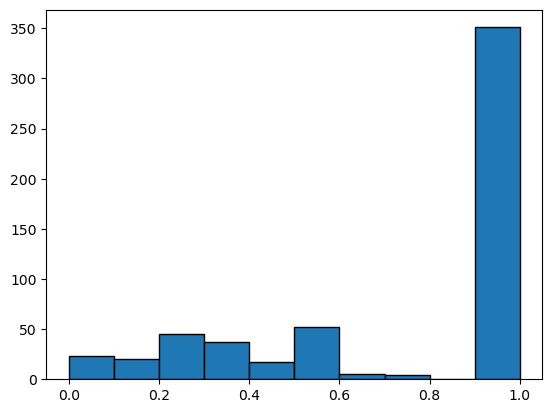

In [ ]:
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.hist(subf.Score, bins=bins, edgecolor="k")